In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb" make docker > /dev/null 2>&1

In [3]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [4]:
import subprocess
import sys


# New TCP Collector
collect = Collector("./config/raw_overrides.yaml")
collect.start_collection()

# Generate some TCP traffic
!nc -l 8080 &  # Listen on port 8080
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 
!echo "testtesttesttesttesttesttesttesttesttest" | nc localhost 8080 

data = collect.stop_collection()

In [5]:
# Analyze TCP branches
import polars as pl
tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])
tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])
tcp_connect_df = pl.read_parquet(data["tcp_v4_connect"][0])

print(tcp_df.group_by("comm").count().sort("count", descending=True))
print(tcp_state_df.group_by("comm").count().sort("count", descending=True))
print(tcp_connect_df.group_by("comm").count().sort("count", descending=True))

nc = tcp_df.filter(pl.col("comm").str.contains("nc"))
nc_state = tcp_state_df.filter(pl.col("comm").str.contains("nc"))
nc_connect = tcp_connect_df.filter(pl.col("comm").str.contains("nc"))

# Show branch distribution
print(nc.group_by("branch_name").count().sort("count", descending=True))
print(nc_state.group_by("event_type_name").count().sort("count", descending=True))
print(nc_connect.group_by("branch_name").count().sort("count", descending=True))

# Show drop reasons
drops = nc.filter(pl.col("drop_reason") > 0)
print(drops.group_by("drop_reason_name").count())

shape: (16, 2)
┌─────────────────┬───────┐
│ comm            ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ jupyter-noteboo ┆ 2700  │
│ sshd            ┆ 2203  │
│ code-2901c5ac6d ┆ 1050  │
│ node            ┆ 922   │
│ python          ┆ 328   │
│ …               ┆ …     │
│ swapper/14      ┆ 4     │
│ swapper/15      ┆ 4     │
│ swapper/12      ┆ 4     │
│ swapper/1       ┆ 2     │
│ swapper/10      ┆ 2     │
└─────────────────┴───────┘
shape: (2, 2)
┌───────────┬───────┐
│ comm      ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ nc        ┆ 18    │
│ swapper/9 ┆ 3     │
└───────────┴───────┘
shape: (1, 2)
┌──────┬───────┐
│ comm ┆ count │
│ ---  ┆ ---   │
│ str  ┆ u32   │
╞══════╪═══════╡
│ nc   ┆ 72    │
└──────┴───────┘
shape: (6, 2)
┌──────────────────┬───────┐
│ branch_name      ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ entry            ┆ 12    

/tmp/ipykernel_21873/2101272489.py:7: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(tcp_df.group_by("comm").count().sort("count", descending=True))
/tmp/ipykernel_21873/2101272489.py:8: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(tcp_state_df.group_by("comm").count().sort("count", descending=True))
/tmp/ipykernel_21873/2101272489.py:9: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(tcp_connect_df.group_by("comm").count().sort("count", descending=True))
/tmp/ipykernel_21873/2101272489.py:16: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(nc.group_by("branch_name").count().sort("count", descending=True))
/tmp/ipykernel_21873/2101272489.py:17: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(nc_state.group_by("event_type_name").count().sort("count", descending=True))
/tmp/ipykernel_21873/2101272489.py:18: Depr

Loaded 7,366 tcp_v4_rcv events
Loaded 21 tcp_state_process events

Sample State Transitions:
shape: (7, 4)
┌───────────┬────────────────┬────────────────┬──────────────┐
│ comm      ┆ old_state_name ┆ new_state_name ┆ ts_uptime_us │
│ ---       ┆ ---            ┆ ---            ┆ ---          │
│ str       ┆ str            ┆ str            ┆ i64          │
╞═══════════╪════════════════╪════════════════╪══════════════╡
│ nc        ┆ STATE_0        ┆ TIME_WAIT      ┆ 10540716089  │
│ swapper/9 ┆ STATE_0        ┆ TIME_WAIT      ┆ 10531329246  │
│ nc        ┆ STATE_0        ┆ TIME_WAIT      ┆ 10540837765  │
│ nc        ┆ STATE_0        ┆ TIME_WAIT      ┆ 10540963280  │
│ nc        ┆ STATE_0        ┆ TIME_WAIT      ┆ 10541208606  │
│ nc        ┆ STATE_0        ┆ TIME_WAIT      ┆ 10541085375  │
│ nc        ┆ STATE_0        ┆ TIME_WAIT      ┆ 10541329481  │
└───────────┴────────────────┴────────────────┴──────────────┘

Event Type Distribution:
shape: (2, 2)
┌─────────────────┬─────┐
│ event_

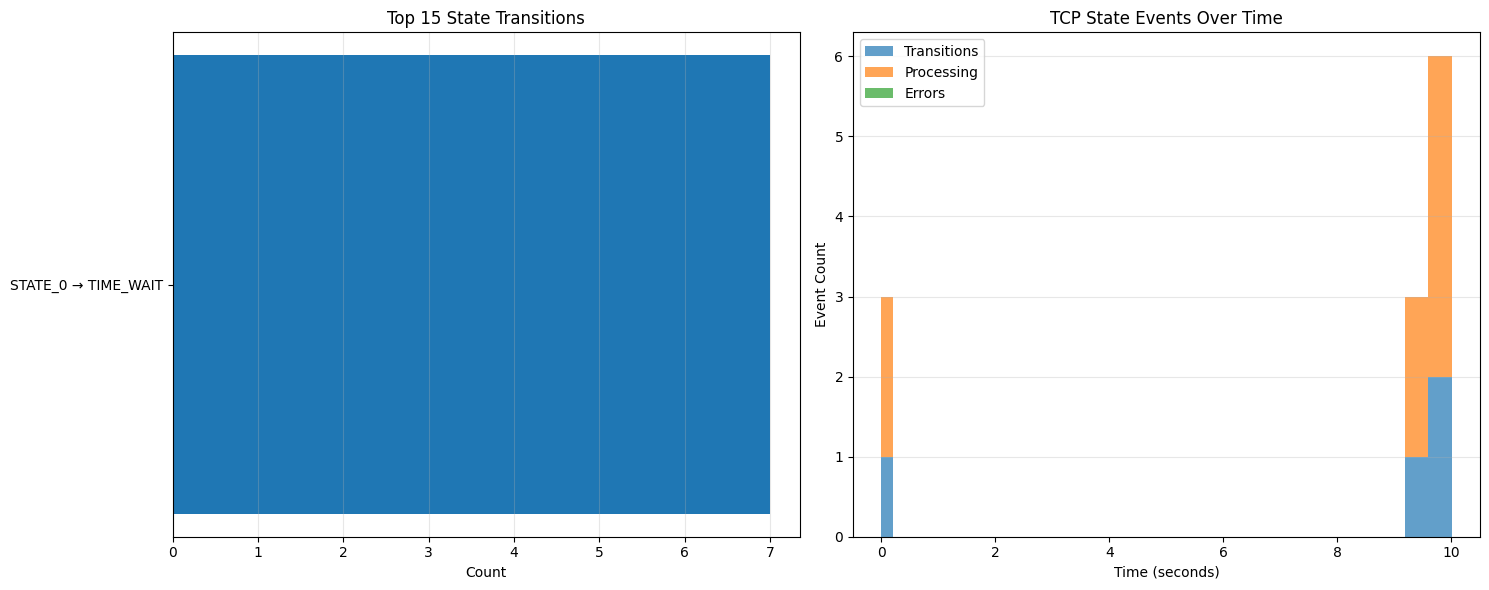


CORRELATION WITH TCP_V4_RCV BRANCH DATA
Time overlap: 10.00 seconds

During overlap period:
- TCP v4 receive events: 3,722
- TCP state events: 18

TCP v4 branches during state processing:
  entry                    :    882 ( 23.7%)
  time_wait                :    871 ( 23.4%)
  established_proc         :    871 ( 23.4%)
  new_syn_recv             :    871 ( 23.4%)
  socket_busy              :    216 (  5.8%)
  no_socket                :     11 (  0.3%)

PERFORMANCE INSIGHTS
Collection duration: 10.00 seconds
Connection establishment rate: 0.0 connections/second
Error rate: 0.00%
Total state transitions: 7

State distribution (PROCESSING events):
  SYN_SENT       :      7 events
  LISTEN         :      6 events
  STATE_0        :      1 events

Potential Issues:


In [6]:
# Cell 1: Load and prepare data
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

# Load the data (assuming data dict is already populated from previous cells)
tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])
tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])

print(f"Loaded {len(tcp_df):,} tcp_v4_rcv events")
print(f"Loaded {len(tcp_state_df):,} tcp_state_process events")

# Cell 2: Basic exploration of TCP state data
# Show sample of state transitions
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
print("\nSample State Transitions:")
print(transitions.select(['comm', 'old_state_name', 'new_state_name', 'ts_uptime_us']).head(10))

# Show event type distribution
print("\nEvent Type Distribution:")
print(tcp_state_df.group_by('event_type_name').len().sort('len', descending=True))

# Cell 3: Deep dive into specific process (e.g., nc or iperf3)
# Filter for a specific process
process_name = "nc"  # or "iperf3" depending on your test
process_events = tcp_state_df.filter(pl.col('comm').str.contains(process_name))

if len(process_events) > 0:
    print(f"\n{process_name} TCP State Analysis:")
    print(f"Total events: {len(process_events)}")
    
    # Show state progression
    print("\nState progression timeline:")
    timeline = process_events.select(['ts_uptime_us', 'event_type_name', 'old_state_name', 'new_state_name']).sort('ts_uptime_us')
    
    # Convert to relative time in milliseconds
    start_time = timeline['ts_uptime_us'].min()
    timeline_with_relative = timeline.with_columns([
        ((pl.col('ts_uptime_us') - start_time) / 1000).alias('relative_ms')
    ])
    
    # Show key events
    for row in timeline_with_relative.head(20).iter_rows():
        if row[1] == 'TRANSITION':
            print(f"{row[4]:8.1f}ms: {row[2]} → {row[3]}")
        else:
            print(f"{row[4]:8.1f}ms: {row[1]} in {row[3]}")

# Cell 4: Connection lifecycle analysis
print("\n" + "="*50)
print("CONNECTION LIFECYCLE ANALYSIS")
print("="*50)

# Group events by process and analyze connection patterns
connection_patterns = tcp_state_df.group_by('comm').agg([
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_SENT').len().alias('syn_sent_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_RECV').len().alias('syn_recv_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'ESTABLISHED').len().alias('established_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'TIME_WAIT').len().alias('time_wait_count'),
    pl.col('event_type_name').filter(pl.col('event_type_name') == 'ERROR').len().alias('error_count')
]).filter(pl.col('established_count') > 0).sort('established_count', descending=True)

print("Connection patterns by process:")
print(connection_patterns.head(10))

# Cell 5: Visualize state machine flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# State transition graph
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
if len(transitions) > 0:
    # Count transitions
    trans_counts = transitions.group_by(['old_state_name', 'new_state_name']).len().sort('len', descending=True)
    
    # Create a simple flow diagram representation
    states = set()
    for row in trans_counts.iter_rows():
        states.add(row[0])
        states.add(row[1])
    
    # Plot top transitions as a bar chart
    trans_labels = [f"{row[0]} → {row[1]}" for row in trans_counts.head(15).iter_rows()]
    trans_values = [row[2] for row in trans_counts.head(15).iter_rows()]
    
    ax1.barh(range(len(trans_labels)), trans_values)
    ax1.set_yticks(range(len(trans_labels)))
    ax1.set_yticklabels(trans_labels)
    ax1.set_xlabel('Count')
    ax1.set_title('Top 15 State Transitions')
    ax1.grid(axis='x', alpha=0.3)

# Event timeline
# Create time-based event density
start_time = tcp_state_df['ts_uptime_us'].min()
tcp_state_df_time = tcp_state_df.with_columns([
    ((pl.col('ts_uptime_us') - start_time) / 1_000_000).alias('time_seconds')
])

# Create histogram of events over time
time_bins = np.linspace(0, tcp_state_df_time['time_seconds'].max(), 50)
transitions_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'TRANSITION')['time_seconds'].to_numpy()
processing_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'PROCESSING')['time_seconds'].to_numpy()
errors_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'ERROR')['time_seconds'].to_numpy()

ax2.hist([transitions_time, processing_time, errors_time], 
         bins=time_bins, label=['Transitions', 'Processing', 'Errors'], 
         stacked=True, alpha=0.7)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Event Count')
ax2.set_title('TCP State Events Over Time')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Correlate with tcp_v4_rcv data
print("\n" + "="*50)
print("CORRELATION WITH TCP_V4_RCV BRANCH DATA")
print("="*50)

# Find overlapping time windows
tcp_v4_time_range = (tcp_df['ts_uptime_us'].min(), tcp_df['ts_uptime_us'].max())
tcp_state_time_range = (tcp_state_df['ts_uptime_us'].min(), tcp_state_df['ts_uptime_us'].max())

overlap_start = max(tcp_v4_time_range[0], tcp_state_time_range[0])
overlap_end = min(tcp_v4_time_range[1], tcp_state_time_range[1])

if overlap_start < overlap_end:
    print(f"Time overlap: {(overlap_end - overlap_start) / 1_000_000:.2f} seconds")
    
    # Filter both datasets to overlapping time
    tcp_v4_overlap = tcp_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    tcp_state_overlap = tcp_state_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    
    # Analyze patterns
    print(f"\nDuring overlap period:")
    print(f"- TCP v4 receive events: {len(tcp_v4_overlap):,}")
    print(f"- TCP state events: {len(tcp_state_overlap):,}")
    
    # Show branch distribution during state transitions
    print("\nTCP v4 branches during state processing:")
    branch_dist = tcp_v4_overlap.group_by('branch_name').len().sort('len', descending=True)
    for row in branch_dist.head(10).iter_rows():
        print(f"  {row[0]:25}: {row[1]:6,} ({row[1]/len(tcp_v4_overlap)*100:5.1f}%)")

# Cell 7: Performance insights
print("\n" + "="*50)
print("PERFORMANCE INSIGHTS")
print("="*50)

# Calculate metrics
total_time = (tcp_state_df['ts_uptime_us'].max() - tcp_state_df['ts_uptime_us'].min()) / 1_000_000
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
errors = tcp_state_df.filter(pl.col('event_type_name') == 'ERROR')

# Connection establishment rate
new_connections = transitions.filter(pl.col('new_state_name') == 'ESTABLISHED')
connection_rate = len(new_connections) / total_time if total_time > 0 else 0

# Error rate
error_rate = len(errors) / len(tcp_state_df) * 100 if len(tcp_state_df) > 0 else 0

# State distribution
state_dist = tcp_state_df.filter(pl.col('event_type_name') == 'PROCESSING').group_by('new_state_name').len()

print(f"Collection duration: {total_time:.2f} seconds")
print(f"Connection establishment rate: {connection_rate:.1f} connections/second")
print(f"Error rate: {error_rate:.2f}%")
print(f"Total state transitions: {len(transitions):,}")

print("\nState distribution (PROCESSING events):")
for row in state_dist.sort('len', descending=True).iter_rows():
    print(f"  {row[0]:15}: {row[1]:6,} events")

# Identify potential issues
print("\nPotential Issues:")
if error_rate > 1:
    print(f"⚠️  High error rate detected: {error_rate:.2f}%")
    
challenge_acks = tcp_state_df.filter(pl.col('event_subtype_name') == 'CHALLENGE_ACK')
if len(challenge_acks) > 0:
    print(f"⚠️  Challenge ACKs detected: {len(challenge_acks)} (possible SYN flood)")
    
resets = tcp_state_df.filter(pl.col('event_subtype_name') == 'RESET')
if len(resets) > 0:
    print(f"⚠️  Connection resets: {len(resets)}")

# Check for connection leaks
time_wait_trans = transitions.filter(pl.col('new_state_name') == 'TIME_WAIT')
close_trans = transitions.filter(pl.col('new_state_name').str.contains('CLOSE'))
if len(new_connections) > 0:
    close_ratio = (len(time_wait_trans) + len(close_trans)) / len(new_connections)
    if close_ratio < 0.8:
        print(f"⚠️  Possible connection leak: only {close_ratio*100:.1f}% of connections properly closed")

In [7]:
# Simple iperf3 Test - Docker Friendly Version

import subprocess
import time

# First, let's manually test if iperf3 works
print("Testing iperf3 installation...")

# Install iperf3 if needed
install_result = subprocess.run(["which", "iperf3"], capture_output=True)
if install_result.returncode != 0:
    print("Installing iperf3...")
    subprocess.run(["apt-get", "update"], capture_output=True)
    subprocess.run(["apt-get", "install", "-y", "iperf3"], capture_output=True)
    print("iperf3 installed!")
else:
    print("iperf3 is already installed")

# Kill any existing iperf3 processes
subprocess.run(["pkill", "-f", "iperf3"], capture_output=True)
time.sleep(1)

# Start iperf3 server manually
print("\nStarting iperf3 server on port 5555...")
server = subprocess.Popen(
    ["iperf3", "-s", "-p", "5555"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for server
time.sleep(3)

# Test connection
print("Testing server connection...")
test = subprocess.run(
    ["iperf3", "-c", "127.0.0.1", "-p", "5555", "-t", "1"],
    capture_output=True,
    text=True
)

if test.returncode == 0:
    print("✓ iperf3 is working!")
    
    # Now run actual benchmark with kernmlops
    print("\nRunning benchmark with kernmlops...")
    
    # Use minimal config for Docker
    collect = Collector("./config/iperf_docker.yaml")
    
    try:
        collect.start_collection(None)
        data = collect.wait()
        
        import polars as pl
        tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])
        print(f"\n✓ Success! Captured {len(tcp_df):,} TCP events")
        
    except Exception as e:
        print(f"\n✗ Benchmark failed: {e}")
        print("\nTry using the alternative method below...")
        
else:
    print("✗ iperf3 server test failed")
    print(f"Error: {test.stderr}")

# Cleanup
server.terminate()
subprocess.run(["pkill", "-f", "iperf3"], capture_output=True)


Testing iperf3 installation...
iperf3 is already installed

Starting iperf3 server on port 5555...
Testing server connection...
✓ iperf3 is working!

Running benchmark with kernmlops...

✓ Success! Captured 3,683 TCP events


CompletedProcess(args=['pkill', '-f', 'iperf3'], returncode=0, stdout=b'', stderr=b'')

In [8]:
# Analyze by process
print(tcp_df.group_by("comm").count().sort("count", descending=True))
iperf_client = tcp_df.filter(pl.col("comm").str.contains("iperf3").and_(~pl.col("comm").str.contains("-s")))

print(f"\nProcess breakdown:")
print(f"- iperf3 client: {len(iperf_client)} events")

# Analyze port 5555 traffic (iperf3 default port)
port_5555 = tcp_df.filter((pl.col("dport") == 5555) | (pl.col("sport") == 5555))
print(f"- Port 5555 traffic: {len(port_5555)} events")

# Branch distribution
print("\nTCP state distribution:")
branch_dist = tcp_df.group_by("branch_name").agg([
    pl.count().alias("count"),
    (pl.count() / len(tcp_df) * 100).alias("percentage")
]).sort("count", descending=True)

for row in branch_dist.head(10).iter_rows():
    print(f"- {row[0]}: {row[1]:,} events ({row[2]:.1f}%)")

# Connection analysis
new_connections = tcp_df.filter(pl.col("branch_name") == "new_syn_recv")
print(f"\nNew TCP connections: {len(new_connections)}")
print(f"Connections per stream: ~{len(new_connections) / 4:.0f}")  # 4 parallel streams

# Drop analysis
drops = tcp_df.filter(pl.col("drop_reason") > 0)
if len(drops) > 0:
    print(f"\nDropped packets: {len(drops)}")
    drop_dist = drops.group_by("drop_reason_name").len()
    for row in drop_dist.iter_rows():
        print(f"- {row[0]}: {row[1]} drops")
else:
    print("\nNo dropped packets detected - excellent!")

# Show branch distribution
print("iperf_client group by branch_name")
print(iperf_client.group_by("branch_name").count().sort("count", descending=True))

# Show drop reasons
drops = iperf_client.filter(pl.col("drop_reason") > 0)
print(drops.group_by("drop_reason_name").count())

shape: (12, 2)
┌─────────────────┬───────┐
│ comm            ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ iperf3          ┆ 3227  │
│ code-2901c5ac6d ┆ 126   │
│ swapper/2       ┆ 92    │
│ sshd            ┆ 76    │
│ swapper/10      ┆ 61    │
│ …               ┆ …     │
│ jupyter-noteboo ┆ 9     │
│ node            ┆ 9     │
│ swapper/8       ┆ 4     │
│ swapper/3       ┆ 4     │
│ python          ┆ 2     │
└─────────────────┴───────┘

Process breakdown:
- iperf3 client: 3227 events
- Port 5555 traffic: 801 events

TCP state distribution:
- entry: 908 events (24.7%)
- time_wait: 907 events (24.6%)
- new_syn_recv: 907 events (24.6%)
- established_proc: 903 events (24.5%)
- socket_busy: 49 events (1.3%)
- do_rcv_direct: 4 events (0.1%)
- listen_state: 4 events (0.1%)
- no_socket: 1 events (0.0%)

New TCP connections: 907
Connections per stream: ~227

Dropped packets: 1
- no_socket: 1 drops
iperf_client group by branch_name
shape: (7, 2)

/tmp/ipykernel_21873/4123034876.py:2: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(tcp_df.group_by("comm").count().sort("count", descending=True))
/tmp/ipykernel_21873/4123034876.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),
/tmp/ipykernel_21873/4123034876.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  (pl.count() / len(tcp_df) * 100).alias("percentage")
/tmp/ipykernel_21873/4123034876.py:39: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(iperf_client.group_by("branch_name").count().sort("count", descending=True))
/tmp/ipykernel_21873/4123034876.py:43: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print(drops.group_by("drop_reason_name").count())


Loaded 3,683 tcp_v4_rcv events
Loaded 35 tcp_state_process events

Sample State Transitions:
shape: (7, 4)
┌───────────┬────────────────┬────────────────┬──────────────┐
│ comm      ┆ old_state_name ┆ new_state_name ┆ ts_uptime_us │
│ ---       ┆ ---            ┆ ---            ┆ ---          │
│ str       ┆ str            ┆ str            ┆ i64          │
╞═══════════╪════════════════╪════════════════╪══════════════╡
│ iperf3    ┆ SYN_RECV       ┆ ESTABLISHED    ┆ 10590499873  │
│ iperf3    ┆ SYN_RECV       ┆ ESTABLISHED    ┆ 10590500362  │
│ swapper/7 ┆ STATE_0        ┆ TIME_WAIT      ┆ 10586923617  │
│ iperf3    ┆ FIN_WAIT1      ┆ FIN_WAIT2      ┆ 10600502938  │
│ iperf3    ┆ STATE_0        ┆ TIME_WAIT      ┆ 10600503036  │
│ iperf3    ┆ FIN_WAIT1      ┆ FIN_WAIT2      ┆ 10600502382  │
│ iperf3    ┆ STATE_0        ┆ TIME_WAIT      ┆ 10600502471  │
└───────────┴────────────────┴────────────────┴──────────────┘

Event Type Distribution:
shape: (2, 2)
┌─────────────────┬─────┐
│ event_

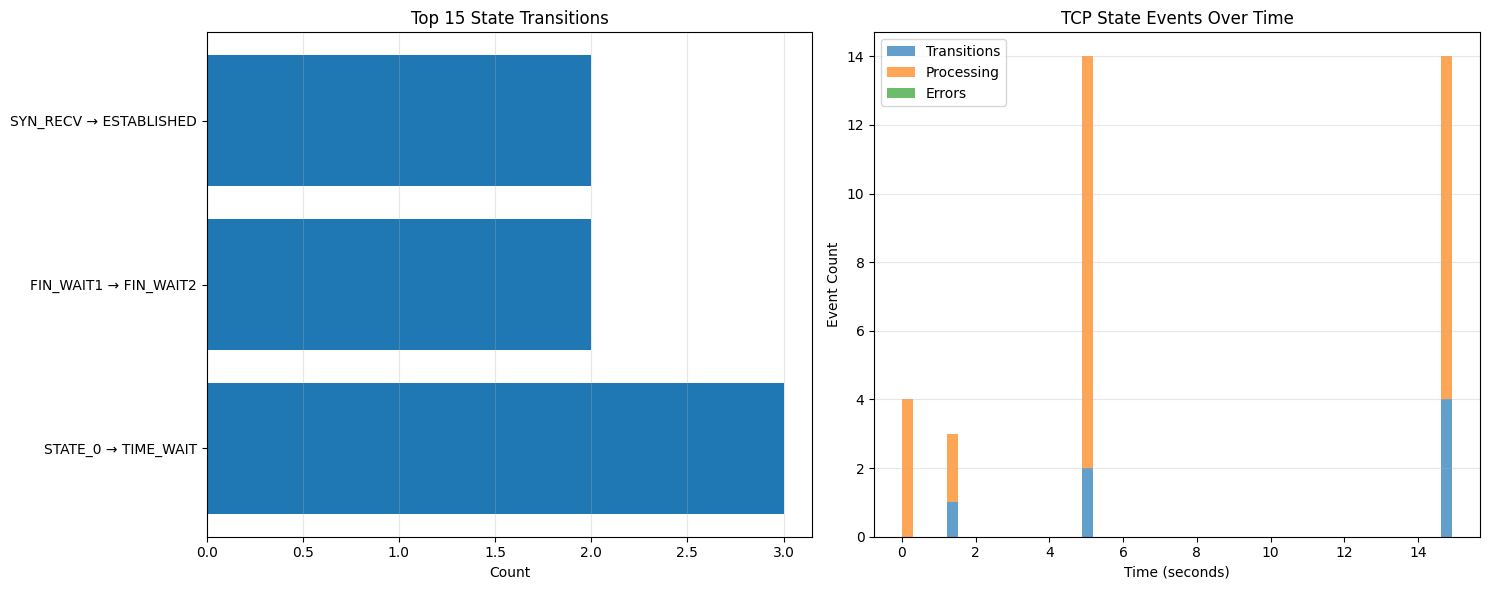


CORRELATION WITH TCP_V4_RCV BRANCH DATA
Time overlap: 14.93 seconds

During overlap period:
- TCP v4 receive events: 3,515
- TCP state events: 35

TCP v4 branches during state processing:
  entry                    :    868 ( 24.7%)
  time_wait                :    867 ( 24.7%)
  new_syn_recv             :    867 ( 24.7%)
  established_proc         :    865 ( 24.6%)
  socket_busy              :     43 (  1.2%)
  listen_state             :      2 (  0.1%)
  do_rcv_direct            :      2 (  0.1%)
  no_socket                :      1 (  0.0%)

PERFORMANCE INSIGHTS
Collection duration: 14.93 seconds
Connection establishment rate: 0.1 connections/second
Error rate: 0.00%
Total state transitions: 7

State distribution (PROCESSING events):
  STATE_0        :     13 events
  SYN_SENT       :     10 events
  LAST_ACK       :      3 events
  LISTEN         :      2 events

Potential Issues:


In [9]:
tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])

print(f"Loaded {len(tcp_df):,} tcp_v4_rcv events")
print(f"Loaded {len(tcp_state_df):,} tcp_state_process events")

# Cell 2: Basic exploration of TCP state data
# Show sample of state transitions
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
print("\nSample State Transitions:")
print(transitions.select(['comm', 'old_state_name', 'new_state_name', 'ts_uptime_us']).head(10))

# Show event type distribution
print("\nEvent Type Distribution:")
print(tcp_state_df.group_by('event_type_name').len().sort('len', descending=True))

# Cell 3: Deep dive into specific process (e.g., nc or iperf3)
# Filter for a specific process
process_name = "iperf3"  # or "iperf3" depending on your test
process_events = tcp_state_df.filter(pl.col('comm').str.contains(process_name))

if len(process_events) > 0:
    print(f"\n{process_name} TCP State Analysis:")
    print(f"Total events: {len(process_events)}")
    
    # Show state progression
    print("\nState progression timeline:")
    timeline = process_events.select(['ts_uptime_us', 'event_type_name', 'old_state_name', 'new_state_name']).sort('ts_uptime_us')
    
    # Convert to relative time in milliseconds
    start_time = timeline['ts_uptime_us'].min()
    timeline_with_relative = timeline.with_columns([
        ((pl.col('ts_uptime_us') - start_time) / 1000).alias('relative_ms')
    ])
    
    # Show key events
    for row in timeline_with_relative.head(20).iter_rows():
        if row[1] == 'TRANSITION':
            print(f"{row[4]:8.1f}ms: {row[2]} → {row[3]}")
        else:
            print(f"{row[4]:8.1f}ms: {row[1]} in {row[3]}")

# Cell 4: Connection lifecycle analysis
print("\n" + "="*50)
print("CONNECTION LIFECYCLE ANALYSIS")
print("="*50)

# Group events by process and analyze connection patterns
connection_patterns = tcp_state_df.group_by('comm').agg([
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_SENT').len().alias('syn_sent_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_RECV').len().alias('syn_recv_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'ESTABLISHED').len().alias('established_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'TIME_WAIT').len().alias('time_wait_count'),
    pl.col('event_type_name').filter(pl.col('event_type_name') == 'ERROR').len().alias('error_count')
]).filter(pl.col('established_count') > 0).sort('established_count', descending=True)

print("Connection patterns by process:")
print(connection_patterns.head(10))

# Cell 5: Visualize state machine flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# State transition graph
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
if len(transitions) > 0:
    # Count transitions
    trans_counts = transitions.group_by(['old_state_name', 'new_state_name']).len().sort('len', descending=True)
    
    # Create a simple flow diagram representation
    states = set()
    for row in trans_counts.iter_rows():
        states.add(row[0])
        states.add(row[1])
    
    # Plot top transitions as a bar chart
    trans_labels = [f"{row[0]} → {row[1]}" for row in trans_counts.head(15).iter_rows()]
    trans_values = [row[2] for row in trans_counts.head(15).iter_rows()]
    
    ax1.barh(range(len(trans_labels)), trans_values)
    ax1.set_yticks(range(len(trans_labels)))
    ax1.set_yticklabels(trans_labels)
    ax1.set_xlabel('Count')
    ax1.set_title('Top 15 State Transitions')
    ax1.grid(axis='x', alpha=0.3)

# Event timeline
# Create time-based event density
start_time = tcp_state_df['ts_uptime_us'].min()
tcp_state_df_time = tcp_state_df.with_columns([
    ((pl.col('ts_uptime_us') - start_time) / 1_000_000).alias('time_seconds')
])

# Create histogram of events over time
time_bins = np.linspace(0, tcp_state_df_time['time_seconds'].max(), 50)
transitions_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'TRANSITION')['time_seconds'].to_numpy()
processing_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'PROCESSING')['time_seconds'].to_numpy()
errors_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'ERROR')['time_seconds'].to_numpy()

ax2.hist([transitions_time, processing_time, errors_time], 
         bins=time_bins, label=['Transitions', 'Processing', 'Errors'], 
         stacked=True, alpha=0.7)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Event Count')
ax2.set_title('TCP State Events Over Time')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Correlate with tcp_v4_rcv data
print("\n" + "="*50)
print("CORRELATION WITH TCP_V4_RCV BRANCH DATA")
print("="*50)

# Find overlapping time windows
tcp_v4_time_range = (tcp_df['ts_uptime_us'].min(), tcp_df['ts_uptime_us'].max())
tcp_state_time_range = (tcp_state_df['ts_uptime_us'].min(), tcp_state_df['ts_uptime_us'].max())

overlap_start = max(tcp_v4_time_range[0], tcp_state_time_range[0])
overlap_end = min(tcp_v4_time_range[1], tcp_state_time_range[1])

if overlap_start < overlap_end:
    print(f"Time overlap: {(overlap_end - overlap_start) / 1_000_000:.2f} seconds")
    
    # Filter both datasets to overlapping time
    tcp_v4_overlap = tcp_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    tcp_state_overlap = tcp_state_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    
    # Analyze patterns
    print(f"\nDuring overlap period:")
    print(f"- TCP v4 receive events: {len(tcp_v4_overlap):,}")
    print(f"- TCP state events: {len(tcp_state_overlap):,}")
    
    # Show branch distribution during state transitions
    print("\nTCP v4 branches during state processing:")
    branch_dist = tcp_v4_overlap.group_by('branch_name').len().sort('len', descending=True)
    for row in branch_dist.head(10).iter_rows():
        print(f"  {row[0]:25}: {row[1]:6,} ({row[1]/len(tcp_v4_overlap)*100:5.1f}%)")

# Cell 7: Performance insights
print("\n" + "="*50)
print("PERFORMANCE INSIGHTS")
print("="*50)

# Calculate metrics
total_time = (tcp_state_df['ts_uptime_us'].max() - tcp_state_df['ts_uptime_us'].min()) / 1_000_000
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
errors = tcp_state_df.filter(pl.col('event_type_name') == 'ERROR')

# Connection establishment rate
new_connections = transitions.filter(pl.col('new_state_name') == 'ESTABLISHED')
connection_rate = len(new_connections) / total_time if total_time > 0 else 0

# Error rate
error_rate = len(errors) / len(tcp_state_df) * 100 if len(tcp_state_df) > 0 else 0

# State distribution
state_dist = tcp_state_df.filter(pl.col('event_type_name') == 'PROCESSING').group_by('new_state_name').len()

print(f"Collection duration: {total_time:.2f} seconds")
print(f"Connection establishment rate: {connection_rate:.1f} connections/second")
print(f"Error rate: {error_rate:.2f}%")
print(f"Total state transitions: {len(transitions):,}")

print("\nState distribution (PROCESSING events):")
for row in state_dist.sort('len', descending=True).iter_rows():
    print(f"  {row[0]:15}: {row[1]:6,} events")

# Identify potential issues
print("\nPotential Issues:")
if error_rate > 1:
    print(f"⚠️  High error rate detected: {error_rate:.2f}%")
    
challenge_acks = tcp_state_df.filter(pl.col('event_subtype_name') == 'CHALLENGE_ACK')
if len(challenge_acks) > 0:
    print(f"⚠️  Challenge ACKs detected: {len(challenge_acks)} (possible SYN flood)")
    
resets = tcp_state_df.filter(pl.col('event_subtype_name') == 'RESET')
if len(resets) > 0:
    print(f"⚠️  Connection resets: {len(resets)}")

# Check for connection leaks
time_wait_trans = transitions.filter(pl.col('new_state_name') == 'TIME_WAIT')
close_trans = transitions.filter(pl.col('new_state_name').str.contains('CLOSE'))
if len(new_connections) > 0:
    close_ratio = (len(time_wait_trans) + len(close_trans)) / len(new_connections)
    if close_ratio < 0.8:
        print(f"⚠️  Possible connection leak: only {close_ratio*100:.1f}% of connections properly closed")

In [ ]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
data = collect.stop_collection()

In [ ]:
# Analyze TCP branches
import polars as pl
tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])

print(tcp_df.group_by("comm").count().sort("count", descending=True))

redis = tcp_df.filter(pl.col("comm").str.contains("redis-server"))

# Show branch distribution
print(redis.group_by("branch_name").count().sort("count", descending=True))

# Show drop reasons
drops = redis.filter(pl.col("drop_reason") > 0)
print(drops.group_by("drop_reason_name").count())

In [ ]:
tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])

print(f"Loaded {len(tcp_df):,} tcp_v4_rcv events")
print(f"Loaded {len(tcp_state_df):,} tcp_state_process events")

# Cell 2: Basic exploration of TCP state data
# Show sample of state transitions
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
print("\nSample State Transitions:")
print(transitions.select(['comm', 'old_state_name', 'new_state_name', 'ts_uptime_us']).head(10))

# Show event type distribution
print("\nEvent Type Distribution:")
print(tcp_state_df.group_by('event_type_name').len().sort('len', descending=True))

# Cell 3: Deep dive into specific process (e.g., nc or iperf3)
# Filter for a specific process
process_name = "redis-server"  # or "iperf3" depending on your test
process_events = tcp_state_df.filter(pl.col('comm').str.contains(process_name))

if len(process_events) > 0:
    print(f"\n{process_name} TCP State Analysis:")
    print(f"Total events: {len(process_events)}")
    
    # Show state progression
    print("\nState progression timeline:")
    timeline = process_events.select(['ts_uptime_us', 'event_type_name', 'old_state_name', 'new_state_name']).sort('ts_uptime_us')
    
    # Convert to relative time in milliseconds
    start_time = timeline['ts_uptime_us'].min()
    timeline_with_relative = timeline.with_columns([
        ((pl.col('ts_uptime_us') - start_time) / 1000).alias('relative_ms')
    ])
    
    # Show key events
    for row in timeline_with_relative.head(20).iter_rows():
        if row[1] == 'TRANSITION':
            print(f"{row[4]:8.1f}ms: {row[2]} → {row[3]}")
        else:
            print(f"{row[4]:8.1f}ms: {row[1]} in {row[3]}")

# Cell 4: Connection lifecycle analysis
print("\n" + "="*50)
print("CONNECTION LIFECYCLE ANALYSIS")
print("="*50)

# Group events by process and analyze connection patterns
connection_patterns = tcp_state_df.group_by('comm').agg([
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_SENT').len().alias('syn_sent_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_RECV').len().alias('syn_recv_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'ESTABLISHED').len().alias('established_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'TIME_WAIT').len().alias('time_wait_count'),
    pl.col('event_type_name').filter(pl.col('event_type_name') == 'ERROR').len().alias('error_count')
]).filter(pl.col('established_count') > 0).sort('established_count', descending=True)

print("Connection patterns by process:")
print(connection_patterns.head(10))

# Cell 5: Visualize state machine flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# State transition graph
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
if len(transitions) > 0:
    # Count transitions
    trans_counts = transitions.group_by(['old_state_name', 'new_state_name']).len().sort('len', descending=True)
    
    # Create a simple flow diagram representation
    states = set()
    for row in trans_counts.iter_rows():
        states.add(row[0])
        states.add(row[1])
    
    # Plot top transitions as a bar chart
    trans_labels = [f"{row[0]} → {row[1]}" for row in trans_counts.head(15).iter_rows()]
    trans_values = [row[2] for row in trans_counts.head(15).iter_rows()]
    
    ax1.barh(range(len(trans_labels)), trans_values)
    ax1.set_yticks(range(len(trans_labels)))
    ax1.set_yticklabels(trans_labels)
    ax1.set_xlabel('Count')
    ax1.set_title('Top 15 State Transitions')
    ax1.grid(axis='x', alpha=0.3)

# Event timeline
# Create time-based event density
start_time = tcp_state_df['ts_uptime_us'].min()
tcp_state_df_time = tcp_state_df.with_columns([
    ((pl.col('ts_uptime_us') - start_time) / 1_000_000).alias('time_seconds')
])

# Create histogram of events over time
time_bins = np.linspace(0, tcp_state_df_time['time_seconds'].max(), 50)
transitions_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'TRANSITION')['time_seconds'].to_numpy()
processing_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'PROCESSING')['time_seconds'].to_numpy()
errors_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'ERROR')['time_seconds'].to_numpy()

ax2.hist([transitions_time, processing_time, errors_time], 
         bins=time_bins, label=['Transitions', 'Processing', 'Errors'], 
         stacked=True, alpha=0.7)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Event Count')
ax2.set_title('TCP State Events Over Time')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Correlate with tcp_v4_rcv data
print("\n" + "="*50)
print("CORRELATION WITH TCP_V4_RCV BRANCH DATA")
print("="*50)

# Find overlapping time windows
tcp_v4_time_range = (tcp_df['ts_uptime_us'].min(), tcp_df['ts_uptime_us'].max())
tcp_state_time_range = (tcp_state_df['ts_uptime_us'].min(), tcp_state_df['ts_uptime_us'].max())

overlap_start = max(tcp_v4_time_range[0], tcp_state_time_range[0])
overlap_end = min(tcp_v4_time_range[1], tcp_state_time_range[1])

if overlap_start < overlap_end:
    print(f"Time overlap: {(overlap_end - overlap_start) / 1_000_000:.2f} seconds")
    
    # Filter both datasets to overlapping time
    tcp_v4_overlap = tcp_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    tcp_state_overlap = tcp_state_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    
    # Analyze patterns
    print(f"\nDuring overlap period:")
    print(f"- TCP v4 receive events: {len(tcp_v4_overlap):,}")
    print(f"- TCP state events: {len(tcp_state_overlap):,}")
    
    # Show branch distribution during state transitions
    print("\nTCP v4 branches during state processing:")
    branch_dist = tcp_v4_overlap.group_by('branch_name').len().sort('len', descending=True)
    for row in branch_dist.head(10).iter_rows():
        print(f"  {row[0]:25}: {row[1]:6,} ({row[1]/len(tcp_v4_overlap)*100:5.1f}%)")

# Cell 7: Performance insights
print("\n" + "="*50)
print("PERFORMANCE INSIGHTS")
print("="*50)

# Calculate metrics
total_time = (tcp_state_df['ts_uptime_us'].max() - tcp_state_df['ts_uptime_us'].min()) / 1_000_000
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
errors = tcp_state_df.filter(pl.col('event_type_name') == 'ERROR')

# Connection establishment rate
new_connections = transitions.filter(pl.col('new_state_name') == 'ESTABLISHED')
connection_rate = len(new_connections) / total_time if total_time > 0 else 0

# Error rate
error_rate = len(errors) / len(tcp_state_df) * 100 if len(tcp_state_df) > 0 else 0

# State distribution
state_dist = tcp_state_df.filter(pl.col('event_type_name') == 'PROCESSING').group_by('new_state_name').len()

print(f"Collection duration: {total_time:.2f} seconds")
print(f"Connection establishment rate: {connection_rate:.1f} connections/second")
print(f"Error rate: {error_rate:.2f}%")
print(f"Total state transitions: {len(transitions):,}")

print("\nState distribution (PROCESSING events):")
for row in state_dist.sort('len', descending=True).iter_rows():
    print(f"  {row[0]:15}: {row[1]:6,} events")

# Identify potential issues
print("\nPotential Issues:")
if error_rate > 1:
    print(f"⚠️  High error rate detected: {error_rate:.2f}%")
    
challenge_acks = tcp_state_df.filter(pl.col('event_subtype_name') == 'CHALLENGE_ACK')
if len(challenge_acks) > 0:
    print(f"⚠️  Challenge ACKs detected: {len(challenge_acks)} (possible SYN flood)")
    
resets = tcp_state_df.filter(pl.col('event_subtype_name') == 'RESET')
if len(resets) > 0:
    print(f"⚠️  Connection resets: {len(resets)}")

# Check for connection leaks
time_wait_trans = transitions.filter(pl.col('new_state_name') == 'TIME_WAIT')
close_trans = transitions.filter(pl.col('new_state_name').str.contains('CLOSE'))
if len(new_connections) > 0:
    close_ratio = (len(time_wait_trans) + len(close_trans)) / len(new_connections)
    if close_ratio < 0.8:
        print(f"⚠️  Possible connection leak: only {close_ratio*100:.1f}% of connections properly closed")

In [ ]:
# Create collector with XSBench configuration
collect = Collector("./config/xsbench.yaml")

# Start collection and run XSBench
print("Starting collection with XSBench workload...")
collect.start_collection(None)

# Wait for XSBench to complete
print("Running XSBench benchmark...")
data = collect.stop_collection()




In [ ]:
# Analyze TCP traffic generated by XSBench
print("\nAnalyzing TCP traffic from XSBench:")
tcp_df = pl.read_parquet(data["tcp_v4_rcv"][0])

# Show branch distribution
print("\nTCP branch distribution:")
print(tcp_df.group_by("branch_name").len().sort("len", descending=True))

# Show drop reasons if any
drops = tcp_df.filter(pl.col("drop_reason") > 0)
if len(drops) > 0:
    print("\nDropped packets:")
    print(drops.group_by("drop_reason_name").len())
else:
    print("\nNo dropped packets detected")

# Show process-specific TCP activity
print("\nTCP activity by process:")
process_tcp = tcp_df.group_by("comm").len().sort("len", descending=True).head(10)
print(process_tcp)

# Check for XSBench-specific activity
xsbench_traffic = tcp_df.filter(pl.col("comm").str.contains("XSBench"))
if len(xsbench_traffic) > 0:
    print(f"\nXSBench generated {len(xsbench_traffic)} TCP events")
else:
    print("\nNo direct TCP traffic from XSBench process detected")

In [ ]:
tcp_state_df = pl.read_parquet(data["tcp_state_process"][0])

print(f"Loaded {len(tcp_df):,} tcp_v4_rcv events")
print(f"Loaded {len(tcp_state_df):,} tcp_state_process events")

# Cell 2: Basic exploration of TCP state data
# Show sample of state transitions
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
print("\nSample State Transitions:")
print(transitions.select(['comm', 'old_state_name', 'new_state_name', 'ts_uptime_us']).head(10))

# Show event type distribution
print("\nEvent Type Distribution:")
print(tcp_state_df.group_by('event_type_name').len().sort('len', descending=True))

# Cell 3: Deep dive into specific process (e.g., nc or iperf3)
# Filter for a specific process
process_name = "XSBench"  # or "iperf3" depending on your test
process_events = tcp_state_df.filter(pl.col('comm').str.contains(process_name))

if len(process_events) > 0:
    print(f"\n{process_name} TCP State Analysis:")
    print(f"Total events: {len(process_events)}")
    
    # Show state progression
    print("\nState progression timeline:")
    timeline = process_events.select(['ts_uptime_us', 'event_type_name', 'old_state_name', 'new_state_name']).sort('ts_uptime_us')
    
    # Convert to relative time in milliseconds
    start_time = timeline['ts_uptime_us'].min()
    timeline_with_relative = timeline.with_columns([
        ((pl.col('ts_uptime_us') - start_time) / 1000).alias('relative_ms')
    ])
    
    # Show key events
    for row in timeline_with_relative.head(20).iter_rows():
        if row[1] == 'TRANSITION':
            print(f"{row[4]:8.1f}ms: {row[2]} → {row[3]}")
        else:
            print(f"{row[4]:8.1f}ms: {row[1]} in {row[3]}")

# Cell 4: Connection lifecycle analysis
print("\n" + "="*50)
print("CONNECTION LIFECYCLE ANALYSIS")
print("="*50)

# Group events by process and analyze connection patterns
connection_patterns = tcp_state_df.group_by('comm').agg([
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_SENT').len().alias('syn_sent_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'SYN_RECV').len().alias('syn_recv_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'ESTABLISHED').len().alias('established_count'),
    pl.col('event_type_name').filter(pl.col('new_state_name') == 'TIME_WAIT').len().alias('time_wait_count'),
    pl.col('event_type_name').filter(pl.col('event_type_name') == 'ERROR').len().alias('error_count')
]).filter(pl.col('established_count') > 0).sort('established_count', descending=True)

print("Connection patterns by process:")
print(connection_patterns.head(10))

# Cell 5: Visualize state machine flow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# State transition graph
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
if len(transitions) > 0:
    # Count transitions
    trans_counts = transitions.group_by(['old_state_name', 'new_state_name']).len().sort('len', descending=True)
    
    # Create a simple flow diagram representation
    states = set()
    for row in trans_counts.iter_rows():
        states.add(row[0])
        states.add(row[1])
    
    # Plot top transitions as a bar chart
    trans_labels = [f"{row[0]} → {row[1]}" for row in trans_counts.head(15).iter_rows()]
    trans_values = [row[2] for row in trans_counts.head(15).iter_rows()]
    
    ax1.barh(range(len(trans_labels)), trans_values)
    ax1.set_yticks(range(len(trans_labels)))
    ax1.set_yticklabels(trans_labels)
    ax1.set_xlabel('Count')
    ax1.set_title('Top 15 State Transitions')
    ax1.grid(axis='x', alpha=0.3)

# Event timeline
# Create time-based event density
start_time = tcp_state_df['ts_uptime_us'].min()
tcp_state_df_time = tcp_state_df.with_columns([
    ((pl.col('ts_uptime_us') - start_time) / 1_000_000).alias('time_seconds')
])

# Create histogram of events over time
time_bins = np.linspace(0, tcp_state_df_time['time_seconds'].max(), 50)
transitions_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'TRANSITION')['time_seconds'].to_numpy()
processing_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'PROCESSING')['time_seconds'].to_numpy()
errors_time = tcp_state_df_time.filter(pl.col('event_type_name') == 'ERROR')['time_seconds'].to_numpy()

ax2.hist([transitions_time, processing_time, errors_time], 
         bins=time_bins, label=['Transitions', 'Processing', 'Errors'], 
         stacked=True, alpha=0.7)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Event Count')
ax2.set_title('TCP State Events Over Time')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 6: Correlate with tcp_v4_rcv data
print("\n" + "="*50)
print("CORRELATION WITH TCP_V4_RCV BRANCH DATA")
print("="*50)

# Find overlapping time windows
tcp_v4_time_range = (tcp_df['ts_uptime_us'].min(), tcp_df['ts_uptime_us'].max())
tcp_state_time_range = (tcp_state_df['ts_uptime_us'].min(), tcp_state_df['ts_uptime_us'].max())

overlap_start = max(tcp_v4_time_range[0], tcp_state_time_range[0])
overlap_end = min(tcp_v4_time_range[1], tcp_state_time_range[1])

if overlap_start < overlap_end:
    print(f"Time overlap: {(overlap_end - overlap_start) / 1_000_000:.2f} seconds")
    
    # Filter both datasets to overlapping time
    tcp_v4_overlap = tcp_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    tcp_state_overlap = tcp_state_df.filter(
        (pl.col('ts_uptime_us') >= overlap_start) & 
        (pl.col('ts_uptime_us') <= overlap_end)
    )
    
    # Analyze patterns
    print(f"\nDuring overlap period:")
    print(f"- TCP v4 receive events: {len(tcp_v4_overlap):,}")
    print(f"- TCP state events: {len(tcp_state_overlap):,}")
    
    # Show branch distribution during state transitions
    print("\nTCP v4 branches during state processing:")
    branch_dist = tcp_v4_overlap.group_by('branch_name').len().sort('len', descending=True)
    for row in branch_dist.head(10).iter_rows():
        print(f"  {row[0]:25}: {row[1]:6,} ({row[1]/len(tcp_v4_overlap)*100:5.1f}%)")

# Cell 7: Performance insights
print("\n" + "="*50)
print("PERFORMANCE INSIGHTS")
print("="*50)

# Calculate metrics
total_time = (tcp_state_df['ts_uptime_us'].max() - tcp_state_df['ts_uptime_us'].min()) / 1_000_000
transitions = tcp_state_df.filter(pl.col('event_type_name') == 'TRANSITION')
errors = tcp_state_df.filter(pl.col('event_type_name') == 'ERROR')

# Connection establishment rate
new_connections = transitions.filter(pl.col('new_state_name') == 'ESTABLISHED')
connection_rate = len(new_connections) / total_time if total_time > 0 else 0

# Error rate
error_rate = len(errors) / len(tcp_state_df) * 100 if len(tcp_state_df) > 0 else 0

# State distribution
state_dist = tcp_state_df.filter(pl.col('event_type_name') == 'PROCESSING').group_by('new_state_name').len()

print(f"Collection duration: {total_time:.2f} seconds")
print(f"Connection establishment rate: {connection_rate:.1f} connections/second")
print(f"Error rate: {error_rate:.2f}%")
print(f"Total state transitions: {len(transitions):,}")

print("\nState distribution (PROCESSING events):")
for row in state_dist.sort('len', descending=True).iter_rows():
    print(f"  {row[0]:15}: {row[1]:6,} events")

# Identify potential issues
print("\nPotential Issues:")
if error_rate > 1:
    print(f"⚠️  High error rate detected: {error_rate:.2f}%")
    
challenge_acks = tcp_state_df.filter(pl.col('event_subtype_name') == 'CHALLENGE_ACK')
if len(challenge_acks) > 0:
    print(f"⚠️  Challenge ACKs detected: {len(challenge_acks)} (possible SYN flood)")
    
resets = tcp_state_df.filter(pl.col('event_subtype_name') == 'RESET')
if len(resets) > 0:
    print(f"⚠️  Connection resets: {len(resets)}")

# Check for connection leaks
time_wait_trans = transitions.filter(pl.col('new_state_name') == 'TIME_WAIT')
close_trans = transitions.filter(pl.col('new_state_name').str.contains('CLOSE'))
if len(new_connections) > 0:
    close_ratio = (len(time_wait_trans) + len(close_trans)) / len(new_connections)
    if close_ratio < 0.8:
        print(f"⚠️  Possible connection leak: only {close_ratio*100:.1f}% of connections properly closed")